## House Prices Prediction - Remote model training using Azure ML compute and Hyperdrive

### In this tutorial we will perform the same basic data preparation and model training steps as we did before, but know with the help of Azure ML service for remote model training and model hyperparameter search on Azure ML compute.

#### We begin by importing the necessary packages and setting some notebook options.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, time

from azureml.core import Experiment
from azureml.core import Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import Model

from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import HyperDriveConfig
from azureml.train.hyperdrive import PrimaryMetricGoal
from azureml.train.hyperdrive.parameter_expressions import choice

from azureml.widgets import RunDetails

warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

#### Before running the next cell, we need to create an Azure ML service Workspace. Follow the instructions [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-workspace) and then download the config.json file. Then, upload that file to your config folder.
#### Now we instantiate a [Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspaces) object, using the information from the configuration file that we uploaded previously.

In [2]:
ws = Workspace.from_config(path="./config/ws_config.json")

#### Next, we instantiate an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiments) object, which will later be used to submit our model training execution.

In [3]:
exp = Experiment(workspace=ws, name="house_prices_hyperdrive")

#### As we are going to run our model training in a remote environment, we need to make the training data available to an external storage accessible to that environment . Here we are going to upload the training data to the [Default Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#datasets-and-datastores), which is available from our Workspace.

In [4]:
ds = ws.get_default_datastore()

In [5]:
ds.upload(src_dir="./data", target_path="data", overwrite=True, show_progress=True)

Uploading an estimated of 1 files
Uploading ./data/ames.csv
Uploaded ./data/ames.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_f6e081d43bd44a809f011068460657f7

#### The next step is to create our remote [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-targets).
#### Here we create one of the type [Azure Machine Learning Compute](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute). Once created, this resource is persisted and accessible by its name in subsequent calls.

In [6]:
cluster_name = "compute01"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print("Found existing compute target")
except ComputeTargetException:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_DS2_V2", 
                                                           max_nodes=12)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


#### Now we create an [Estimator](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#estimators) object. Estimator facilitate the creation of run configurations, by defining [run scripts](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-azure-machine-learning-architecture#training-scripts), its parameters and the target run environment.
#### Azure ML service provides a generic Estimator, as well as specialized ones that facilitate the usage of several popular python ML packages. Here we use the [SKLearn](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.estimator?view=azure-ml-py) Estimator, as we are going to train Scikit-Learn based models.

In [7]:
script_folder = "./scripts"

script_params = {
    "--data-folder": ds.as_mount()
}

estimator = SKLearn(source_directory=script_folder, 
                    compute_target=compute_target,
                    entry_script="train_model.py",
                    script_params=script_params
                   )

#### We are going to submit our Estimator for remote run on Azure ML Compute. Instead of doing that directly, we will wrap it using the [HyperDrive](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters) functionality for automated model hyperparameter search.

#### The first step is to define how to sample the hyperparameter space. Azure ML service provides several strategies already built in. Here we will use standard [Grid Sampling](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters#sampling-the-hyperparameter-space).

In [8]:
param_sampling = GridParameterSampling({
    "n-estimators": choice(500, 750, 1000),
    "max-depth": choice(4, 6),
    "min-samples-split": choice(2, 4),
    "learning-rate": choice(0.01, 0.001)
})

#### After defining the Estimator and grid sampling strategy, we can pass them to the [Hyper Drive configuration](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive.hyperdriveconfig?view=azure-ml-py) object. There are several options to configure here, such as the [termination policy](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters#specify-early-termination-policy), [resources](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters#allocate-resources) to allocate the job on, and the [primary metric](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters#specify-primary-metric) to be optimized.

In [9]:
hyperdrive_run_config = HyperDriveConfig(estimator=estimator,
                                         hyperparameter_sampling=param_sampling,
                                         policy=None,
                                         primary_metric_name="test_MAE",
                                         primary_metric_goal=PrimaryMetricGoal.MINIMIZE,
                                         max_total_runs=100,
                                         max_concurrent_runs=24)

#### The remaining step is to submit the Experiment defined before, passing the configuration fot the hyperparameter search.

In [10]:
hyperdrive_run = exp.submit(hyperdrive_run_config)

#### We can monitor the execution through a Jupyter [graphical widget](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters#visualize-experiment), available through the RunDetails class.

In [15]:
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

#### After all executions generated by the hyperparameter search finish, we can inspect them and print the hyperparameters and correspondig model performance metrics in a table.
#### Here this table is ordered by the best model according to the Mean Absolute Error computed for the test dataset.

In [16]:
children = list(hyperdrive_run.get_children())
metricslist = {}
i = 0
    
for single_run in children:
    results = {k: v for k, v in single_run.get_metrics().items() if isinstance(v, float)}
    parameters = single_run.get_details()["runDefinition"]["arguments"]
    try:
        results["n-estimators"] = parameters[3]
        results["max-depth"] = parameters[5]
        results["min-samples-split"] = parameters[7]
        results["learning-rate"] = parameters[9]
        metricslist[i] = results
        i += 1
    except:
        pass

rundata = pd.DataFrame(metricslist).sort_index(1).T.sort_values(by=["test_MAE"], ascending=True)
display(rundata)

,learning-rate,max-depth,min-samples-split,n-estimators,test_MAE,test_R2,train_MAE,train_R2,val_MAE,val_R2E
11,0.01,4,4,1000,14370.2,0.903886,7949.93,0.983512,14766.1,0.900702
8,0.01,4,2,1000,14396.6,0.904527,7960.03,0.98361,14824.6,0.899076
0,0.01,4,4,750,14483.2,0.90454,8700.07,0.979903,15007.2,0.898939
3,0.01,4,2,750,14517.7,0.903964,8700.21,0.98003,15014.4,0.898548
21,0.01,4,4,500,14837.5,0.902211,9971.84,0.972792,15416.3,0.895565
23,0.01,4,2,500,14840.4,0.901704,9973.57,0.9729,15430.6,0.89587
4,0.01,6,4,1000,15222.8,0.882993,3719.9,0.9966,15129.4,0.896742
18,0.01,6,4,750,15260.6,0.886841,4328.41,0.995471,15248.5,0.895221
6,0.01,6,2,1000,15263.7,0.883208,3684.44,0.99669,15180.7,0.894688
16,0.01,6,2,750,15318.2,0.880839,4282.11,0.995602,15267.3,0.894395


#### We can also access directly the best run from our hyperdrive execution and then have access to the generated log files and the outputs we create explicitly.

In [17]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run.id

'house_prices_hyperdrive_1572035965388836_8'

#### All files that we write to the special "outputs" folder are made available for each hyperdrive run. Here we list those generated by the best run.

In [18]:
file_names = best_run.get_file_names()
file_names

['azureml-logs/55_azureml-execution-tvmps_6f64a1dc6520a4e52b169daa2f5fe7b6fcef4a0eb1ba2917d04343b2537f908a_d.txt',
 'azureml-logs/65_job_prep-tvmps_6f64a1dc6520a4e52b169daa2f5fe7b6fcef4a0eb1ba2917d04343b2537f908a_d.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/75_job_post-tvmps_6f64a1dc6520a4e52b169daa2f5fe7b6fcef4a0eb1ba2917d04343b2537f908a_d.txt',
 'azureml-logs/process_info.json',
 'azureml-logs/process_status.json',
 'logs/azureml/135_azureml.log',
 'logs/azureml/azureml.log',
 'outputs/gbr_1000_4_4_0.01.pkl',
 'outputs/y_test.pkl',
 'outputs/y_test_predicted.pkl',
 'outputs/y_train.pkl',
 'outputs/y_train_predicted.pkl']

#### We can then retrieve the model and corresponding train and test predictions that we explicitly saved in the run script.

In [19]:
model_folder = "./model"
os.makedirs(model_folder, exist_ok=True)

for f in file_names[-5:]:
    best_run.download_file(f, model_folder)
    
model_name = file_names[-5].split("/")[1]
best_model = joblib.load(os.path.join(model_folder, model_name))

y_pred_train = joblib.load(os.path.join(model_folder, file_names[-1].split("/")[1]))
y_true_train = joblib.load(os.path.join(model_folder, file_names[-2].split("/")[1]))
y_pred_test = joblib.load(os.path.join(model_folder, file_names[-3].split("/")[1]))
y_true_test = joblib.load(os.path.join(model_folder, file_names[-4].split("/")[1]))

In [22]:
best_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

#### Here we compute model performance metrics for train and test datasets.

In [27]:
def MAPE(y_actual, y_predict):
    sum_actuals = sum_errors = 0
    
    for actual_val, predict_val in zip(y_actual, y_predict):
        abs_error = actual_val - predict_val
        if abs_error < 0:
            abs_error = abs_error * -1

        sum_errors = sum_errors + abs_error
        sum_actuals = sum_actuals + actual_val

    return sum_errors / sum_actuals

print("MAPE (Train): %f" % MAPE(y_true_train, y_pred_train))
print("MAPE (Test): %f" % MAPE(y_true_test, y_pred_test))

print("Acc (Train): %f" % (1 - MAPE(y_true_train, y_pred_train)))
print("Acc (Test): %f" % (1 - MAPE(y_true_test, y_pred_test)))

print("MAE (Train): %f" % mean_absolute_error(y_true_train, y_pred_train))
print("MAE (Test): %f" % mean_absolute_error(y_true_test, y_pred_test))

print("R2 (Train): %f" % r2_score(y_true_train, y_pred_train))
print("R2 (Test): %f" % r2_score(y_true_test, y_pred_test))

MAPE (Train): 0.045696
MAPE (Test): 0.079724
Acc (Train): 0.954304
Acc (Test): 0.920276
MAE (Train): 8274.244247
MAE (Test): 14370.196100
R2 (Train): 0.982125
R2 (Test): 0.903886


#### Now let's visualize the plots for predicted versus actual values for both train and test datasets.

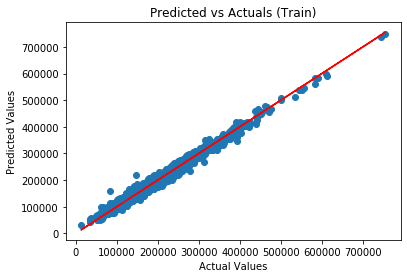

In [28]:
plt.scatter(y=y_pred_train, x=y_true_train)
plt.plot(y_true_train, y_true_train, color="red")
plt.title("Predicted vs Actuals (Train)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

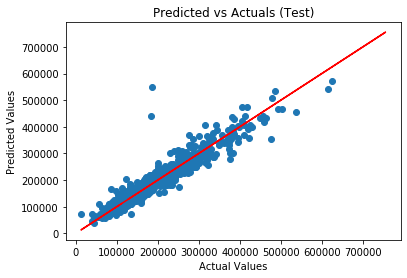

In [29]:
plt.scatter(y=y_pred_test, x=y_true_test)
plt.plot(y_true_train, y_true_train, color="red")
plt.title("Predicted vs Actuals (Test)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

#### Finally, let's plot the error distributions for both train and test datasets.

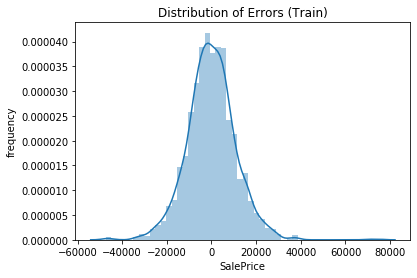

In [30]:
ax = sns.distplot(y_pred_train - y_true_train)
ax.set(title="Distribution of Errors (Train)", xlabel="SalePrice", ylabel="frequency")
plt.show()

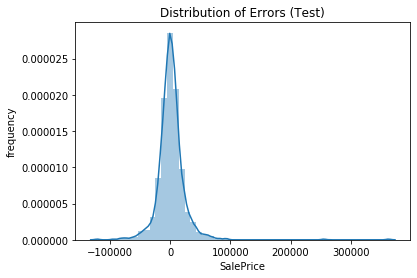

In [31]:
ax = sns.distplot(y_pred_test - y_true_test)
ax.set(title="Distribution of Errors (Test)", xlabel="SalePrice", ylabel="frequency")
plt.show()